## Notebook to visualize the viewer functionality


In [2]:
%load_ext autoreload
%autoreload 2

import pprint


import torch
from nerfactory.viewer.server.visualizer import Viewer
from nerfactory.data.structs import SceneBounds

In [6]:
# connect to the viewer
vis = Viewer(zmq_url="tcp://127.0.0.1:6000")

In [8]:
vis["renderingState/camera"].write({"my data": "hello world"})

/renderingState/camera


b'ok'

In [9]:
# vis["renderingState/camera"].read()

In [10]:
# draw a red box
# viewer_utils.show_box_test(vis)

scene_bounds = SceneBounds(aabb=torch.tensor([[-1, -1, -1], [1, 1, 1]]))
json_ = scene_bounds.to_json()
pprint.pprint(json_)

vis["sceneState/sceneBounds"].write(json_)
json_["min_point"][0] -= 1
vis["sceneState/sceneBounds2"].write(json_)

{'max_point': [1, 1, 1], 'min_point': [-1, -1, -1], 'type': 'aabb'}
/sceneState/sceneBounds
/sceneState/sceneBounds2


b'ok'

In [ ]:

from nerfactory.engine.trainer import Trainer
from hydra import compose, initialize

config_path = "../configs"
initialize(version_base="1.2", config_path=config_path)
config_overrides = []
config_name = "graph_instant_ngp.yaml"
config = compose(config_name, overrides=config_overrides)

In [56]:
trainer = Trainer(config, local_rank=0, world_size=0)
trainer.setup()

2022-07-28 20:43:34.709728: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [11]:
import numpy as np
import torch

""

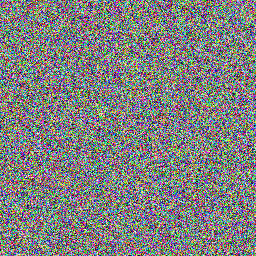

In [12]:
image = torch.rand(256, 256, 3)
import mediapy as media
media.show_image(image)

In [13]:
from nerfactory.cameras.cameras import PinholeCamera

In [22]:
camera = PinholeCamera(cx=100, cy=100, fx=50, fy=50)

In [23]:
json_ = camera.to_json(image=image)

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'imencode'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'


In [18]:
json_

NameError: name 'json_' is not defined

In [16]:
vis[f"sceneState/cameras/temp"].write(camera.to_json(image=image))

NameError: name 'vis' is not defined